
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Climate emulator output generation

inputs required: 
  * emulator output - synthetic wave and water level conditions associated to future TCs probability
  * Projected Sea Level Rise at the Site (for the intermediate SLR scenario, +1m)

in this notebook:
  * plot the synthetic values of the analyzed variables
  * generation of hourly values of the synthetic time series
  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, repair_times_hourly, add_max_storms_mask, fast_reindex_hourly, fast_reindex_hourly_nsim

from teslakit.plotting.outputs import Plot_Complete



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S4
db_S4 = Database(p_data)
db_S4.SetSite('ROI_CC_S4')


# Climate Emulator. simulation modified path
CE = Climate_Emulator(db_S4.paths.site.EXTREMES.climate_emulator)

n_sims_DWTs = 10



## Simulated Waves and Climate Data

In [3]:
def waves_hourly(CE, n_sim, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - select one DWTs-WVS Climate emulator simulations
    - aggregate simulated waves storms
    - generate hourly hydrographs
    
    return xarray.Dataset with dims: time (hourly)
    '''

    # Load DWT --> WVS, TCs simulation 
    _, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n_sim)    
    WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  
    TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)
    
    # aggregate waves families
    WVS_agr = Aggregate_WavesFamilies(WVS_upd, a_tp='max_energy')
        
    # calculate intradaily hourly hydrographs for simulated storms
    WVS_h = Intradaily_Hydrograph(WVS_agr, TCS_sim)
        
    # repair times: remove duplicates (if any)
    WVS_h = repair_times_hourly(WVS_h)
    
    # add mask for max_storms times
    WVS_h = add_max_storms_mask(WVS_h, WVS_upd.time.values)

    return WVS_h
    

In [9]:
# generate simulation covariates hourly data 
CVS = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)


In [12]:
# iterate simulations
for n in range(n_sims_DWTs):
 
    # select covariates simulation
    CVS_s = CVS.sel(n_sim=n)

    # generate hourly waves
    WVS_s = waves_hourly(CE, n)
    
    # merge all data
    d1, d2 = xds_limit_dates([WVS_s, CVS_s])
    WVS_s = WVS_s.sel(time = slice(d1, d2))
    SIM = xr.combine_by_coords([WVS_s, CVS_s])
    
    # set AT reference level (mean at 0)
    SIM['AT'].values[:] = SIM['AT'] - np.nanmean(SIM['AT'])
    
    # calculate AWL, TWL and level
    SIM['AWL'] = AWL(SIM['Hs'], SIM['Tp'])
    SIM['TWL'] = SIM['AWL'] + SIM['SS'] + SIM['AT'] + SIM['MMSL']
    SIM['level'] = SIM['SS'] + SIM['AT'] + SIM['MMSL']
    
    # store hourly simulation offshore data
    db_S4.Save_SIM_OFFSHORE(SIM, n)
    
    print('simulation {0} processed.'.format(n))
    


simulation 0 processed.
simulation 1 processed.
simulation 2 processed.
simulation 3 processed.
simulation 4 processed.
simulation 5 processed.
simulation 6 processed.
simulation 7 processed.
simulation 8 processed.
simulation 9 processed.


<xarray.Dataset>
Dimensions:     (time: 8765832)
Coordinates:
  * time        (time) int64 262968 262969 262970 ... 9028797 9028798 9028799
Data variables:
    SS          (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MJO         (time) float32 23.0 23.0 23.0 23.0 23.0 ... 25.0 25.0 25.0 25.0
    level       (time) float32 0.28164524 0.33136904 ... -0.53276384 -0.72148514
    TWL         (time) float32 1.1731935 1.2205601 ... -0.178404 -0.36946815
    AWT         (time) float32 3.0 3.0 3.0 3.0 3.0 3.0 ... 2.0 2.0 2.0 2.0 2.0
    AWL         (time) float32 0.8915482 0.88919103 ... 0.3543598 0.352017
    max_storms  (time) float32 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MMSL        (time) float32 0.035881303 0.035881303 ... -0.10350889
    Dir         (time) float32 76.70734 76.70734 76.70734 ... 18.413 18.413
    DWT         (time) float32 30.0 30.0 30.0 30.0 30.0 ... 34.0 34.0 34.0 34.0
    AT          (time) float32 0.24576394 0.29548773 ... -0.4292549

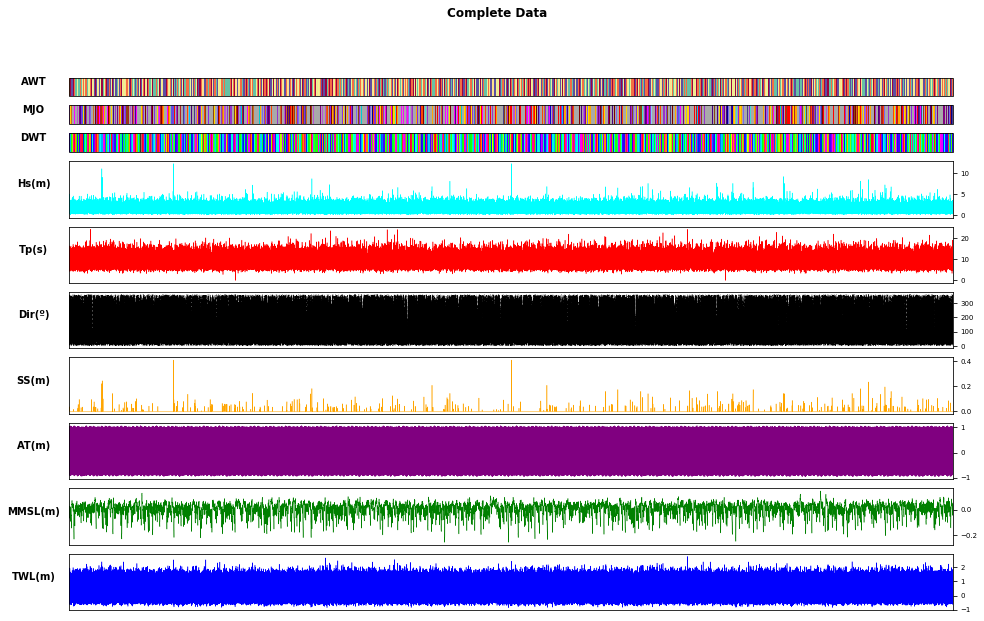

In [13]:
# Plot one Simulation 

n_sim = 0
SIM_p = db_S4.Load_SIM_OFFSHORE(n_sim)
print(SIM_p)

Plot_Complete(SIM_p);


### plot 100 yrs. of TWL taking into account SLR for intermediate scenario

In [14]:
# Load SLR file

SLR = db.Load_SeaLevelRise()
SLR['time'] = SLR.time.dt.round('H')

# Select intermediate scenario (+1.0)
SLR = SLR.sel(scenario='1.0')

print(SLR)

<xarray.Dataset>
Dimensions:   (time: 885360)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 ... 2100-12-31T23:00:00
    scenario  <U3 '1.0'
Data variables:
    SLR       (time) float32 ...


([<matplotlib.lines.Line2D at 0x1bc06d5f8>],
 [],
 (0, 885360),
 <matplotlib.legend.Legend at 0x1bc0852b0>)

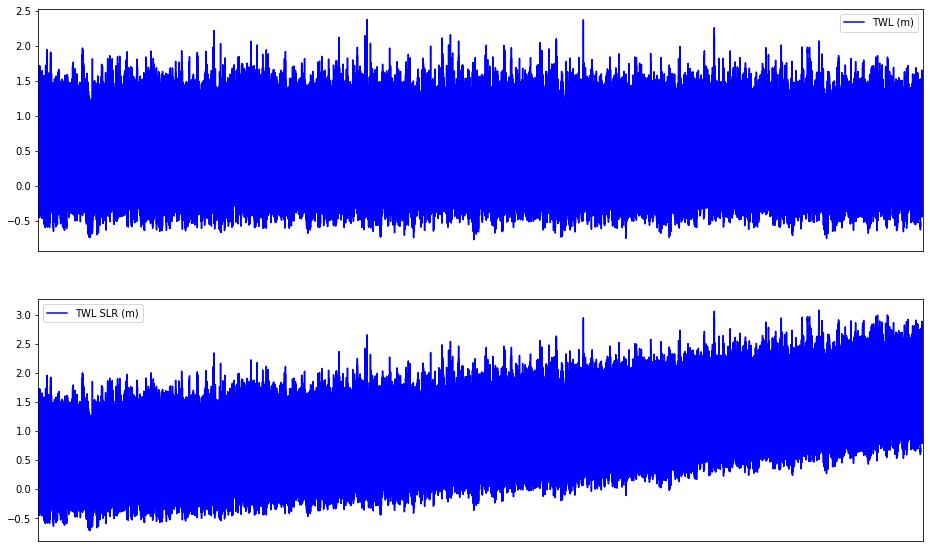

In [15]:
# Keep first 100 years of simulation
SIM_p = SIM_p.isel(time=slice(0, len(SLR.time))) # 100 years

# Add SLR to TWL
SIM_p['TWL_SLR'] = SIM_p['TWL'] + SLR['SLR'].values


# plot figure
from teslakit.plotting.config import _faspect, _fsize
import matplotlib.gridspec as gridspec

fig, axs = plt.subplots(2, 1, figsize=(_faspect*_fsize, _fsize));

# Sim
axs[0].plot(SIM_p.TWL.values, label='TWL (m)', color='blue'), axs[0].set_xticks([]), axs[0].set_xlim(0,len(SIM_p.time)), axs[0].legend()

# Sim with SLR S2
axs[1].plot(SIM_p.TWL_SLR.values, label='TWL SLR (m)', color='blue'), axs[1].set_xticks([]), axs[1].set_xlim(0,len(SIM_p.time)), axs[1].legend()
